In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.stats import bernoulli

In [3]:
def compare(x, y, eps2):
    '''
    Функция, которая сравнивает текущую и предыдущую итерацию
    
    Parameters
    ----------
    x: ndarray, shape (n,)
        Профиль мнений на текущей итерации, состоящий из n агентов
    y: ndarray, shape (n,)
        Профиль мнений на предыдущей итерации, состоящий из n агентов
    eps2: float
        Допустимая точность
        
    Returns
    -------
    result: bool
        True, если произошла "заморозка" модели
        False, если "заморозки" не произошло
    '''
    
    result = 1
    for k in range(len(x)):
        if abs(x[k] - y[k]) >= eps2:
            result = 0
    result = bool(result)
    return result


def new_op_classic(x, i, eps):
    '''
    Функция, которая вычисляет мнение агента на следующей итерации в модели HK 
    
    Parameters
    ----------
    x: ndarray, shape (n,)
        Профиль мнений на предыдущей итерации, состоящий из n агентов
    i: int
        Индекс агента, для которого считаем новое значение
    eps: float
        Радиус доверия
        
    Returns
    -------
    new_value: float
        Новое "мнение" агента
    '''
    
    count = 1
    summ = x[i]
    
    # проходим по всему профилю мнений
    for k in range(len(x)):  
        if (abs(x[i] - x[k]) <= eps) and (i != k):  # ищем "соседей" данного агента
            summ += x[k]  # суммируем значения всех "соседей" данного агента
            count += 1  # сичтаем количество "соседей"
    new_value = summ/count  # новое "мнение" агента
    return new_value


def Hen_Kr_classic(x0, eps, eps2):
    '''
    Функция, которая итерационно вычисляет эволюцию модели HK
    
    Parameters
    ----------
    x0: ndarray, shape (n,)
        Начальный профиль мнений, состоящий из n агентов
    eps: float
        Радиус доверия
    eps2: float
        Допустимая точность. С её помощью определяется момент остановки эволюции модели
        
    Returns
    -------
    X: list, shape (t, n)
        Итоговая матрица эволюции модели, хранящая в себе данные о "мнениях" агентов 
        в каждый момент времени
    t: float
        Общее время эволюции модели
    '''
    
    X = [np.array(x0)]  # формируем список, в котором будут храниться данные о 'мнениях' агентов
    t = 0  # переменная для подсчёта времени (количества итераций)
    
    # цикл для итерационного вычисления эволюции модели
    while True:  
        X.append(np.zeros(len(x0)))  # на каждой итерации добавляем в список вектор из нулей
        t += 1
        
        # цикл для вычисления мнений агентов на следующей итерации
        for j in range(len(x0)):  
            X[t][j] = new_op_classic(X[t - 1], j, eps)
            
            
#         print(order_parameter(X[t], eps, -1))
        # Условие остановки эволюции; проверяем, что профиль мнений на текущей 
        # и предыдущей итерации отличается меньше, чем на заданную допустимую точность
        if compare(X[t], X[t - 1], eps2):  
            break
    return X, t


def order_parameter(x, eps, target_ind=-1):
    summary = 0
    n = len(x)
    for i in range(n):
        if i == target_ind:
            continue
        for j in range(n):
            if j != target_ind:
                if abs(x[i]-x[j]) < eps:
                    summary += 1
                else:
                    continue
    if target_ind == -1:
        return summary/(n**2)
    else:
        return summary/((n-1)**2)


def Hen_Kr_classic_with_order_parameter_mod(x0, eps, eps2):
    X = [np.array(x0)]  # формируем список, в котором будут храниться данные о 'мнениях' агентов
    t = 0  # переменная для подсчёта времени (количества итераций)
    order_array = []
    # цикл для итерационного вычисления эволюции модели
    while True:  
        order_array.append(order_parameter(X[t], eps, -1))
        X.append(np.zeros(len(x0)))  # на каждой итерации добавляем в список вектор из нулей
        t += 1
        
        # цикл для вычисления мнений агентов на следующей итерации
        for j in range(len(x0)):  
            X[t][j] = new_op_classic(X[t - 1], j, eps)
            
#         print(order_parameter(X[t], eps, -1))
        # Условие остановки эволюции; проверяем, что профиль мнений на текущей 
        # и предыдущей итерации отличается меньше, чем на заданную допустимую точность
        if compare(X[t], X[t - 1], eps2):  
            order_array.append(order_parameter(X[t], eps, -1))
            break
    return X, t, order_array

## Модификация функции для стохастической модели

In [4]:
def new_op(x, i, eps):
    count = 1
    summ = x[i]
    for k in range(len(x)):
        if (abs(x[i] - x[k]) < eps) and (i != k):
            # print(i, j, x[i], x[j])
            summ += x[k]
            count += 1
    # print(summ, count)
    return summ/count, count


def Hen_Kr_actm2_order_parameter_mod(x0, eps, eps2, fix, v, prob):
    X = [np.array(x0)]
    t = 0
    order_array = []
    while True:
        order_array.append(order_parameter(X[t], eps, -1))
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=len(x0)-1)
        active_mask = np.insert(active_mask, fix, 1)
        t += 1
        for j in range(len(x0)):
            if j != fix and active_mask[j]==1:
                X_prev = np.copy(X[t - 1])
                X_prev[active_mask==0]=0 - 2*eps - 2*eps2 
                X[t][j], _ = new_op(X_prev, j, eps)
                X[t][active_mask==0] = X[t-1][active_mask==0]
            if j == fix:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if compare(X[t], X[t - 1], eps2):
            order_array.append(order_parameter(X[t], eps, -1))
            break
    return X, t, order_array

### Пример по сбору статистики

In [16]:
n = 300
eps2 = 1e-4
prob = 0.5
epss = np.array(range(1,21,1))
epss = epss/20
nn = np.array(range(10,210,10))
# epss = []
count_experiments = 100

for i in trange(len(epss)):
    order_array = []  # список для списков параметров порядка на каждой итерации 
    max_len_orader_array = 0  # отслеживает максимальное время эволюции
    for j in range(count_experiments):
        x0 = np.random.sample(n)
        x0.sort()
        X, t, order_array_cur = Hen_Kr_actm2_order_parameter_mod(x0, epss[i], eps2, -1, 0, prob)
        
        if len(order_array_cur) > max_len_orader_array:
            max_len_order_array = len(order_array_cur)
        order_array.append(order_array_cur)
        
    # дополнение списков параметров порядка последним значением для равенства по времени эволюции
    for j in range(len(order_array)): 
        if len(order_array[j]) >= max_len_order_array:
            continue
        last_value = order_array[j][-1]
        while len(order_array[j]) < max_len_order_array:
            order_array[j].append(last_value)
    
    average_order = np.zeros(max_len_order_array)  # массив для средних значений параметра порядка для каждого момента времени
    for j in range(max_len_order_array):
        for k in range(count_experiments):
            average_order[j] += order_array[k][j]
            
    average_order = average_order / count_experiments 
    
    np.save(f'average_order_sthk_mod_n{n}_eps_{epss[i]}', average_order)
# average_order

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [39:03<00:00, 117.20s/it]


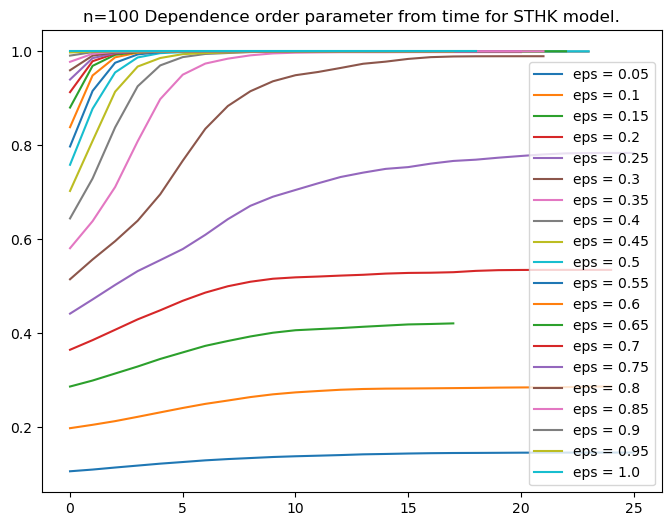

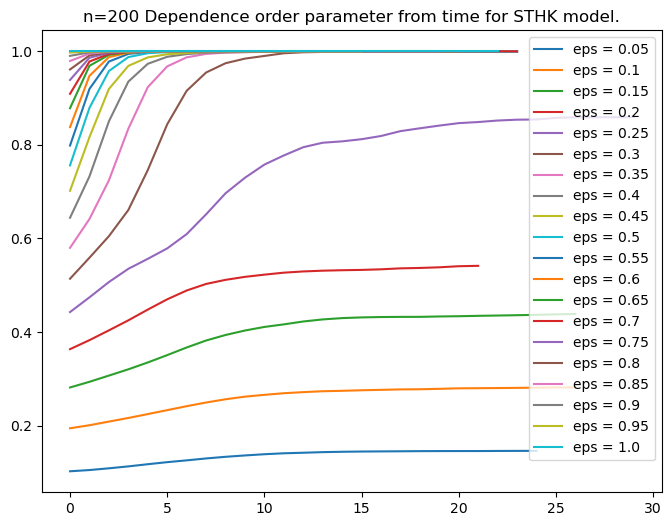

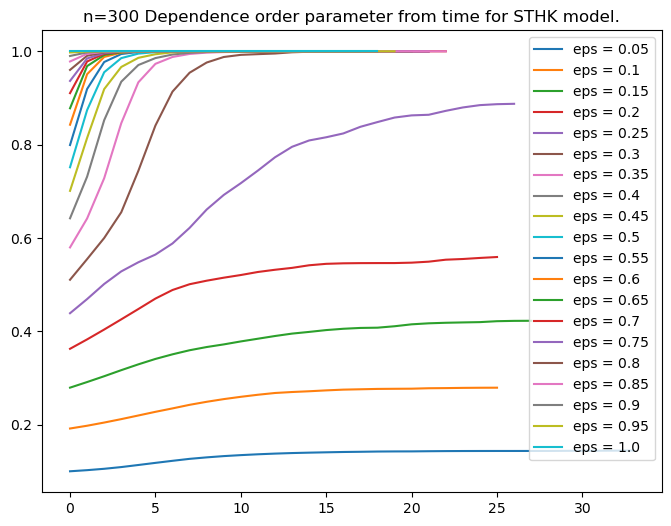

In [20]:
nn = [100,200,300]
# epss = [0.1]
for n in nn:
    plt.figure(facecolor='white', figsize=(8, 6))

    for i in range(len(epss)):
        order_buf = np.load(f'average_order_sthk_mod_n{n}_eps_{epss[i]}.npy')

        t_list = np.linspace(0, len(order_buf) - 1, len(order_buf))
        plt.plot(t_list, order_buf, label=f'eps = {epss[i]}')

    plt.legend()
    plt.title(f'n={n} Dependence order parameter from time for STHK model.')
    plt.show()